In [1]:
import sys

sys.path.append(".")

import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from utils import read_msi
from pathlib import Path
from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from pyimzml.ImzMLParser import ImzMLParser

# Define current folder using this file
CWD = "."
# Define folder that contains the revision chip type dataset
BASE_PATH = Path(os.path.join(CWD, "..", "data", "LONGITUDINAL"))
# Define folder that contains raw data
RAW_DATA = BASE_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = BASE_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = BASE_PATH.joinpath("processed")

In [2]:
def read_image_info(folder_name):
  msi_path = PROCESSED_DATA / folder_name / 'meaningful_signal.imzML'
  msi_seg = np.load(PROCESSED_DATA / folder_name / "segmentation_new.npy")

  with ImzMLParser(msi_path) as p:
    mzs, img = read_msi(p)
    mzs_filter = (mzs >= 600) & (mzs <= 900)
    img_filter = img[:, :, mzs_filter]

  return img_filter, mzs[mzs_filter], msi_seg


def perform_hierarchical_clustering(pixels, n_clusters):
  # Perform hierarchical clustering
  clustering = AgglomerativeClustering(
      n_clusters=n_clusters, linkage='ward', compute_distances=True
  )
  clustering.fit(pixels)
  return clustering


def plot_clusters(label_image, n_clusters=3, cbar=False):
  #
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(n_clusters)]
  colors = np.vstack(([1, 1, 1, 1], selected_colors))
  custom_cmap = ListedColormap(colors)

  #flipped_label_image = np.fliplr(label_image)
  seg_c_map = plt.imshow(label_image, cmap=custom_cmap, vmin=0, vmax=n_clusters)
  if cbar:
    cbar = plt.colorbar(
        seg_c_map, ticks=np.arange(1, n_clusters + 1),
        boundaries=np.arange(0.5, n_clusters + 1.5)
    )
    cbar.set_ticklabels(range(1, n_clusters + 1))
    cbar.set_label(
        'Cluster', labelpad=15, fontweight='bold', fontsize=14, color='0.2'
    )
    cbar.outline.set_edgecolor('0.2')
    cbar.ax.tick_params(labelsize=14, width=2.5, color='0.2')
    for l in cbar.ax.get_yticklabels():
      l.set_fontweight('bold')
      l.set_color('0.2')
  plt.axis('off')
  plt.tight_layout()
  plt.show()


def get_sample_name(s):
  if len(s.split("rep_")) > 1:
    return "day_" + s.split("day_")[1].split("_"
                                            )[0] + "_rep_" + s.split("rep_")[1]
  return "day_" + s.split("day_")[1].split("_")[0]

In [3]:
samples_groups = [
    ["tmz_1_tumor_brain_3_day_0_0_uM", "tmz_1_tumor_brain_3_day_5_0_uM_rep_1"],
    [
        "tmz_2_tumor_brain_3_day_0_1000_uM",
        "tmz_2_tumor_brain_3_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_4_day_0_0_uM", "tmz_tumor_brain_4_day_5_0_uM_rep_2"],
    [
        "tmz_tumor_brain_4_day_0_1000_uM",
        "tmz_tumor_brain_4_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_5_day_0_0_uM", "tmz_tumor_brain_5_day_5_0_uM_rep_3"],
    [
        "tmz_2_tumor_brain_5_day_0_1000_uM",
        "tmz_2_tumor_brain_5_day_5_1000_uM_rep_3"
    ], ["tmz_tumor_brain_6_day_0_0_uM", "tmz_tumor_brain_6_day_5_0_uM_rep_3"],
    [
        "tmz_tumor_brain_6_day_0_1000_uM",
        "tmz_tumor_brain_6_day_5_1000_uM_rep_2"
    ]
]

In [4]:
gaussian_sigma = 1.0
n_clusters = 4

img_original_list = []
img_list = []
mzs_list = []
seg_list = []

for sample in np.array(samples_groups).flatten():
  img, mzs, seg = read_image_info(sample)

  img_original_list.append(img)
  mzs_list.append(mzs)
  seg_list.append(seg)

  img[~seg] = 0

  img_smoothed = ndimage.gaussian_filter(img, sigma=gaussian_sigma)
  img_scaled = np.zeros_like(img)
  img_scaled[seg] = MinMaxScaler(clip=True).fit_transform(img_smoothed[seg])
  img_with_res = np.zeros_like(img)
  for i, mz in enumerate(mzs):
    mzs_mask = (mzs >= mz - 0.025) & (mzs <= mz + 0.025)
    img_with_res[:, :, i] = np.sum(img_scaled[:, :, mzs_mask], axis=-1)
  img_list.append(img_with_res)

In [5]:
thresh = 2
significant_lipids = []
for img, seg in zip(img_original_list, seg_list):
  significant_lipids.append(img[seg].mean(axis=0) >= thresh)

In [6]:
significant_lipids_in_all_0 = True

for i in range(0, len(significant_lipids), 2):
  significant_lipids_in_all_0 &= significant_lipids[i]

In [7]:
significant_lipids_in_all_5 = True
for i in range(1, len(significant_lipids) + 1, 2):
  significant_lipids_in_all_5 &= significant_lipids[i]

In [8]:
img_original_list = None

In [9]:
def perform_hierarchical_clustering(pixels, n_clusters):
  # Perform hierarchical clustering
  clustering = AgglomerativeClustering(
      n_clusters=n_clusters, linkage='ward', compute_distances=True
  )
  clustering.fit(pixels)
  return clustering


def plot_clusters(label_image, n_clusters=3, cbar=False):
  #
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(n_clusters)]
  colors = np.vstack(([1, 1, 1, 1], selected_colors))
  custom_cmap = ListedColormap(colors)

  #flipped_label_image = np.fliplr(label_image)
  seg_c_map = plt.imshow(label_image, cmap=custom_cmap, vmin=0, vmax=n_clusters)
  if cbar:
    cbar = plt.colorbar(
        seg_c_map, ticks=np.arange(1, n_clusters + 1),
        boundaries=np.arange(0.5, n_clusters + 1.5)
    )
    cbar.set_ticklabels(range(1, n_clusters + 1))
    cbar.set_label(
        'Cluster', labelpad=15, fontweight='bold', fontsize=14, color='0.2'
    )
    cbar.outline.set_edgecolor('0.2')
    cbar.ax.tick_params(labelsize=14, width=2.5, color='0.2')
    for l in cbar.ax.get_yticklabels():
      l.set_fontweight('bold')
      l.set_color('0.2')
  plt.axis('off')
  plt.tight_layout()
  plt.show()


def get_sample_name(s):
  if len(s.split("rep_")) > 1:
    return "day_" + s.split("day_")[1].split("_"
                                            )[0] + "_rep_" + s.split("rep_")[1]
  return "day_" + s.split("day_")[1].split("_")[0]

tmz_tumor_brain_6_day_5_1000_uM_rep_2


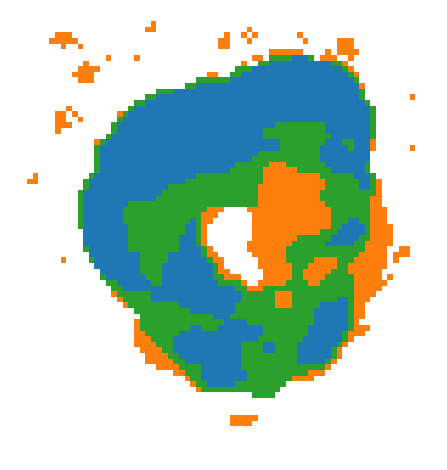

tmz_tumor_brain_6_day_5_1000_uM_rep_2


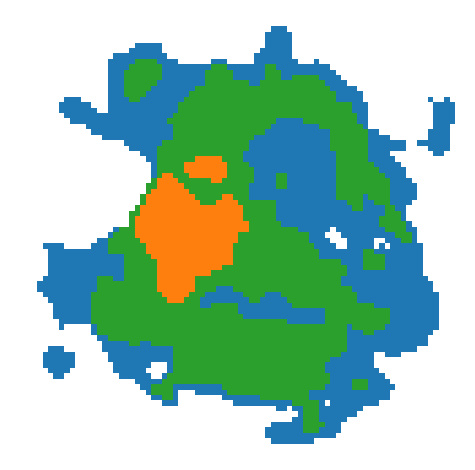

tmz_tumor_brain_6_day_5_1000_uM_rep_2


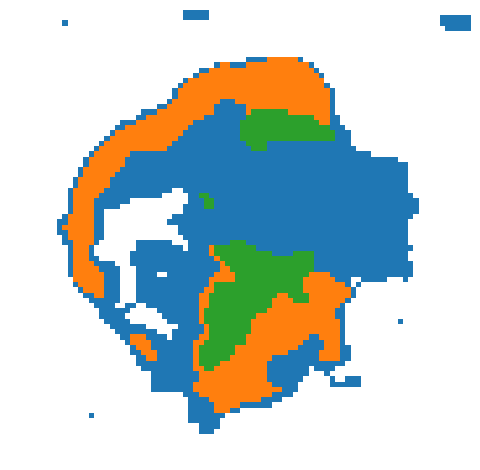

tmz_tumor_brain_6_day_5_1000_uM_rep_2


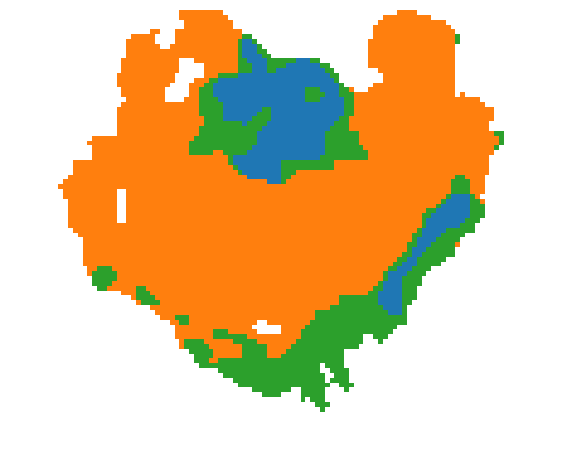

tmz_tumor_brain_6_day_5_1000_uM_rep_2


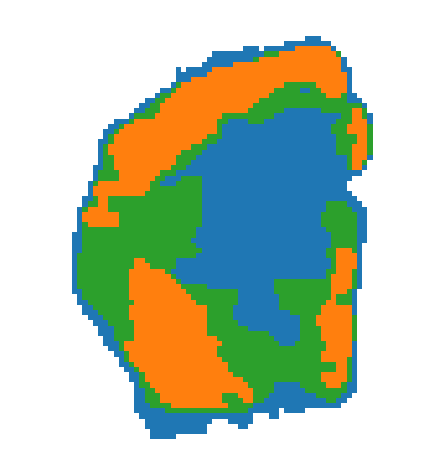

tmz_tumor_brain_6_day_5_1000_uM_rep_2


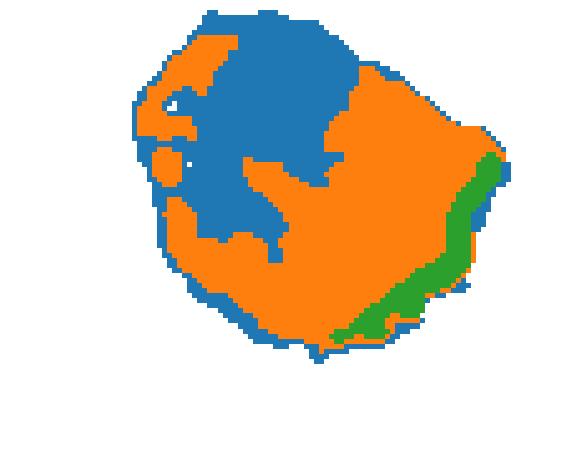

tmz_tumor_brain_6_day_5_1000_uM_rep_2


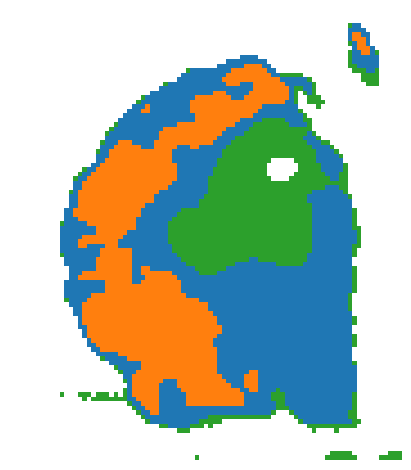

tmz_tumor_brain_6_day_5_1000_uM_rep_2


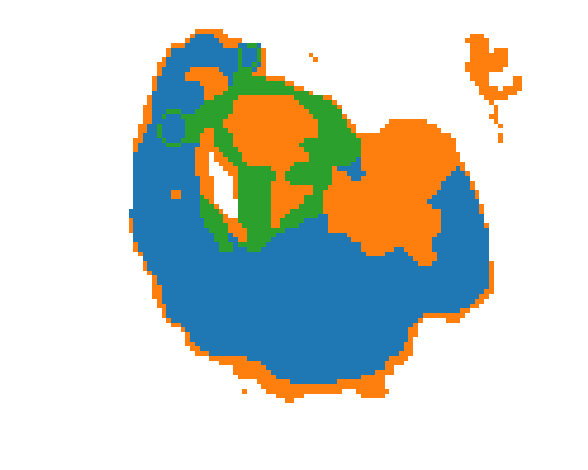

tmz_tumor_brain_6_day_5_1000_uM_rep_2


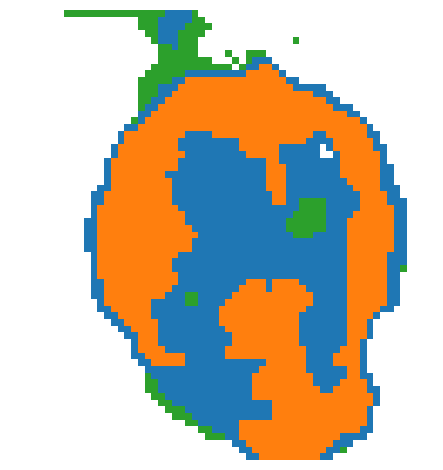

tmz_tumor_brain_6_day_5_1000_uM_rep_2


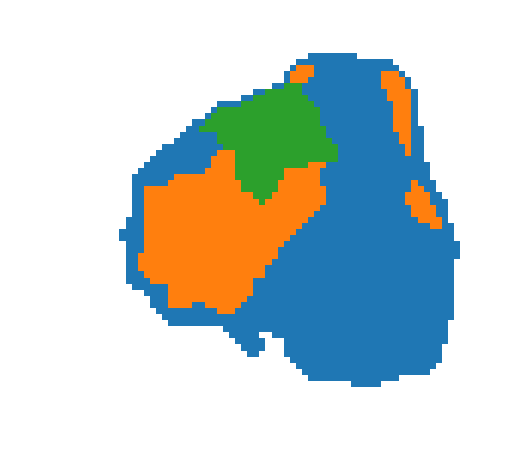

tmz_tumor_brain_6_day_5_1000_uM_rep_2


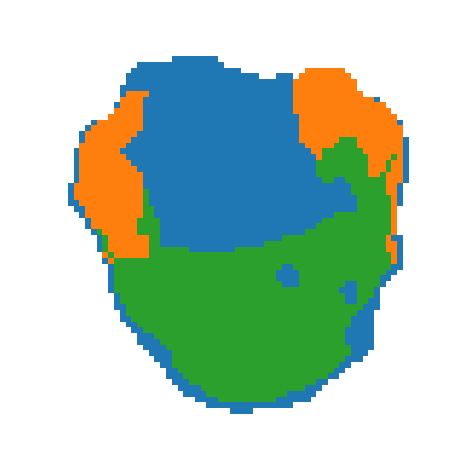

tmz_tumor_brain_6_day_5_1000_uM_rep_2


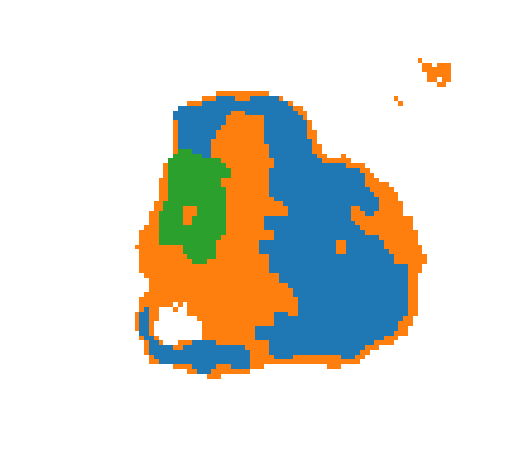

tmz_tumor_brain_6_day_5_1000_uM_rep_2


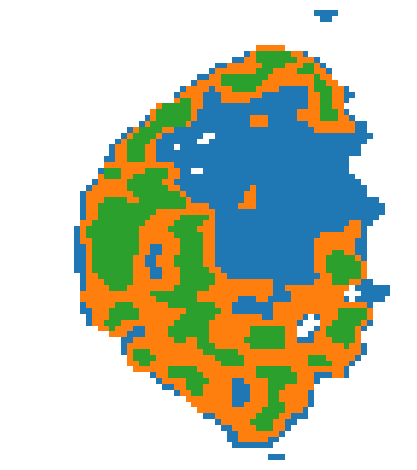

tmz_tumor_brain_6_day_5_1000_uM_rep_2


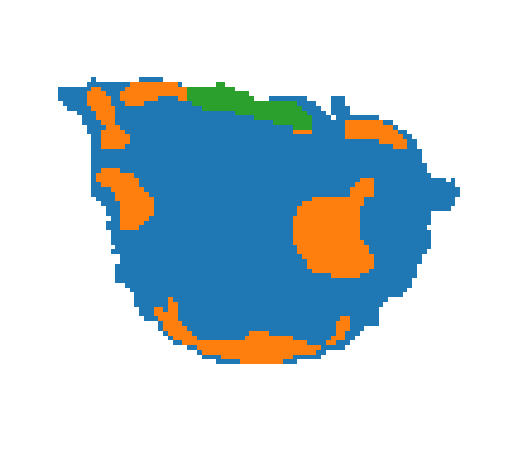

tmz_tumor_brain_6_day_5_1000_uM_rep_2


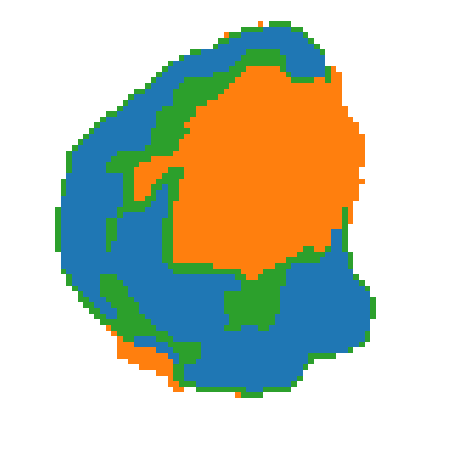

tmz_tumor_brain_6_day_5_1000_uM_rep_2


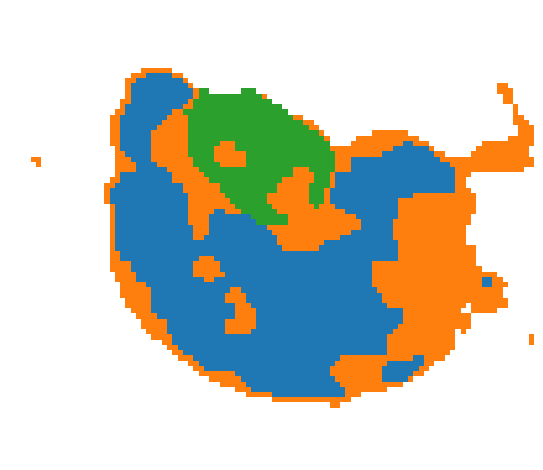

In [11]:
load_models = False

save_path = Path("./longitudinal/hca_gaussian_new_significant/")
save_path.mkdir(parents=True, exist_ok=True)

n_clusters = 3

cluster_labels_list = []

for img, mzs, seg in zip(img_list, mzs_list, seg_list):
  img_significant = img[:,:, significant_lipids_in_all_0]
  if load_models:
    hca = joblib.load(save_path / f"{sample}.pkl")
  else:
    hca = perform_hierarchical_clustering(img_significant[seg], n_clusters)
    joblib.dump(hca, save_path / f"{sample}.pkl")

  cluster_labels = np.zeros(img.shape[:-1])
  cluster_labels[seg] = hca.labels_ + 1
  cluster_labels_list.append(cluster_labels)

  print(sample)
  plot_clusters(cluster_labels, n_clusters)